# Predicting music genres from Spotify data

My project aims to develop a machine learning model capable of predicting the genre of a song. The prediction will be based on features ranging from the music field, such as tempo, key, and time signature, to the lyrics domain, including speechiness and explicitness, and will consider aspects related to how the song is perceived by the public, such as popularity and danceability. All of this, along with other relevant information, is extracted from a database entirely based on the leading streaming platform Spotify.

The dataset can be found here: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

In [124]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.random_projection import SparseRandomProjection
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier, OutputCodeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from ipywidgets import interact

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


# Let's have a look at the data

In [125]:
df_original = pd.read_csv('dataset.csv')

In [126]:
df_original.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


We can observe the dataset structure: each row corresponds to a different song, and the columns contain the features we will utilize for genre prediction, with the genre itself located in the final column.

We drop the following columns since they are not going to be used by the model.

In [127]:
df_original.drop(['Unnamed: 0', 'track_id', 'album_name', 'track_name'], axis = 1, inplace = True)

## Dataset size manipulation

The original dataset contains 114 unique values in the genre column, with each genre having 1000 instances. While the project functions with the original dataset (albeit with some overfitting), we will resize it to ensure our machine can handle it effectively. This step may be unnecessary for machines with high computational power.

The new dataset will include 10 random genres selected from the original 114. Additionally, I've incorporated an option to adjust the number of samples for each genre, allowing for testing the model with a broader range of genres while maintaining a manageable dataset size. It's important to note that altering the sample numbers will impact the model's performance. For this specific run, I'll retain the original 1000 samples for each genre.

To prevent any potential bias in genre recognition by the model based on grouping, I will shuffle the rows of the dataset.

In [128]:
selected_genres = np.random.choice(df_original['track_genre'].unique(), size=10, replace=False)

sampled_instances = [df_original[df_original['track_genre'] == genre].copy() for genre in selected_genres]

df_sampled = pd.concat(sampled_instances)

df_sampled = df_sampled.sample(frac=1, random_state=42)

In [129]:
df = pd.concat([group.sample(n=1000, random_state=42) for _, group in df_sampled.groupby('track_genre')])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [130]:
df['track_genre'].value_counts()

track_genre
rock-n-roll      1000
honky-tonk       1000
drum-and-bass    1000
ambient          1000
opera            1000
forro            1000
romance          1000
heavy-metal      1000
techno           1000
songwriter       1000
Name: count, dtype: int64

In [131]:
df.shape

(10000, 17)

# Features

The model will base its predictions on the following features:

- artists: the artists' names who performed the track

- popularity: the popularity of a track is a value between 0 and 100

- explicit: whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)

- danceability: danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity

- energy: it represents a perceptual measure of intensity and activity

- key: the key the track is in

- loudness: the overall loudness of a track in decibels (dB)

- mode: it indicates the modality (major or minor) of a track

- speechiness: it detects the presence of spoken words in a track

- acousticness: a confidence measure of whether the track is acoustic

- instrumentalness: it predicts whether a track contains no vocals

- liveness: it detects the presence of an audience in the recording

- valence: a measure describing the musical positiveness conveyed by a track

- tempo: the overall estimated tempo of a track in beats per minute (BPM)

- time_signature: an estimated time signature; it ranges from 3 to 7 indicating time signatures of 3/4, to 7/4


## Where are the missing values?

As shown in the matrix below, the data are perfectly complete, without any missing values.

<AxesSubplot: >

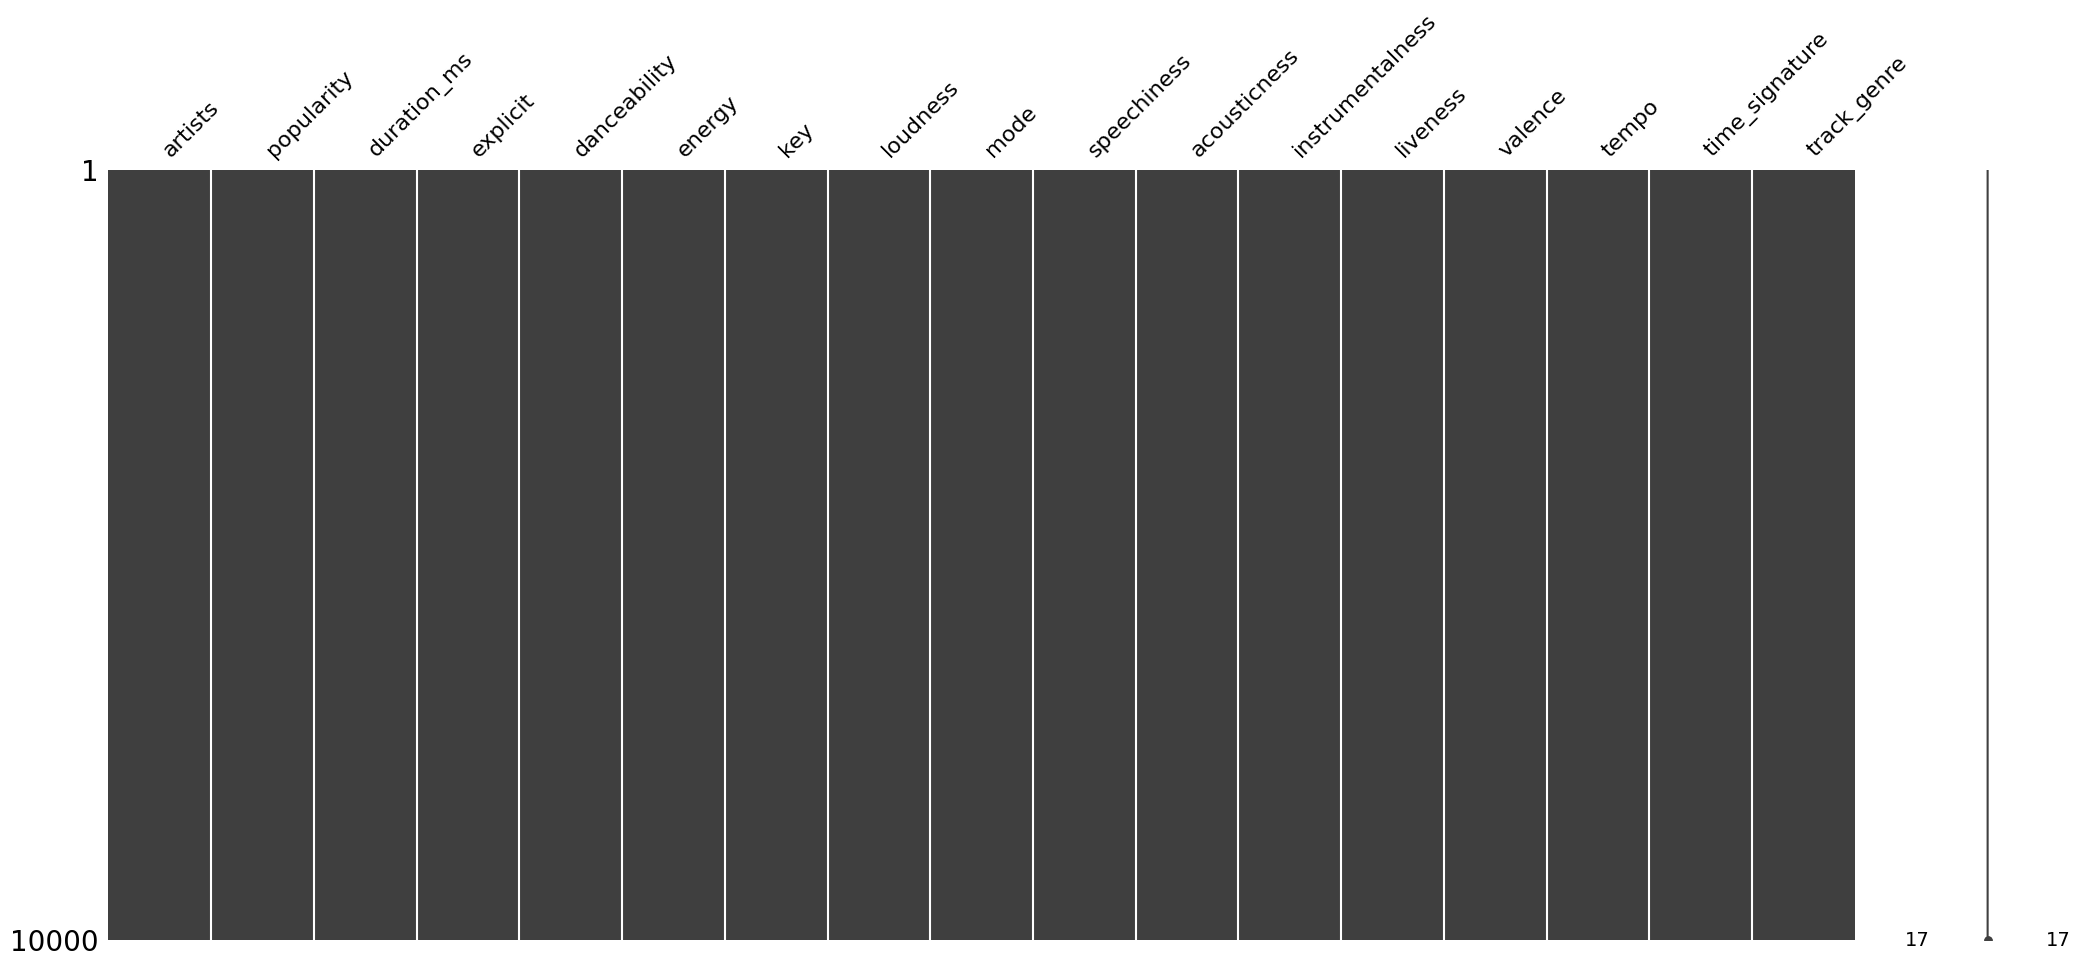

In [132]:
msno.matrix(df)

In [133]:
df.isnull().sum(axis=0)

artists             0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

We apply the custom function "add_missing" to certain columns in our dataset to demonstrate how to handle missing values later.

In [134]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

In [135]:
df['danceability'] = add_missing(df['danceability'], 0.02)
df['energy'] = add_missing(df['energy'], 0.05)
df['liveness'] = add_missing(df['liveness'], 0.05)
df['valence'] = add_missing(df['valence'], 0.08)
df['time_signature'] = add_missing(df['time_signature'], 0.08)

We drop any row that now has three or more missing values, as imputing too many values for a single row would lead to inaccurate predictions.

Although I didn't modify the "artists" column, it already showed one missing value in the genre "k-pop". Hence, I added a step to drop that specific row in case this genre would be selected.

In [136]:
df.dropna(subset = ['artists'], inplace = True)
df.dropna(thresh=3, inplace = True)

The following is the new status of the data regarding NaN values.

<AxesSubplot: >

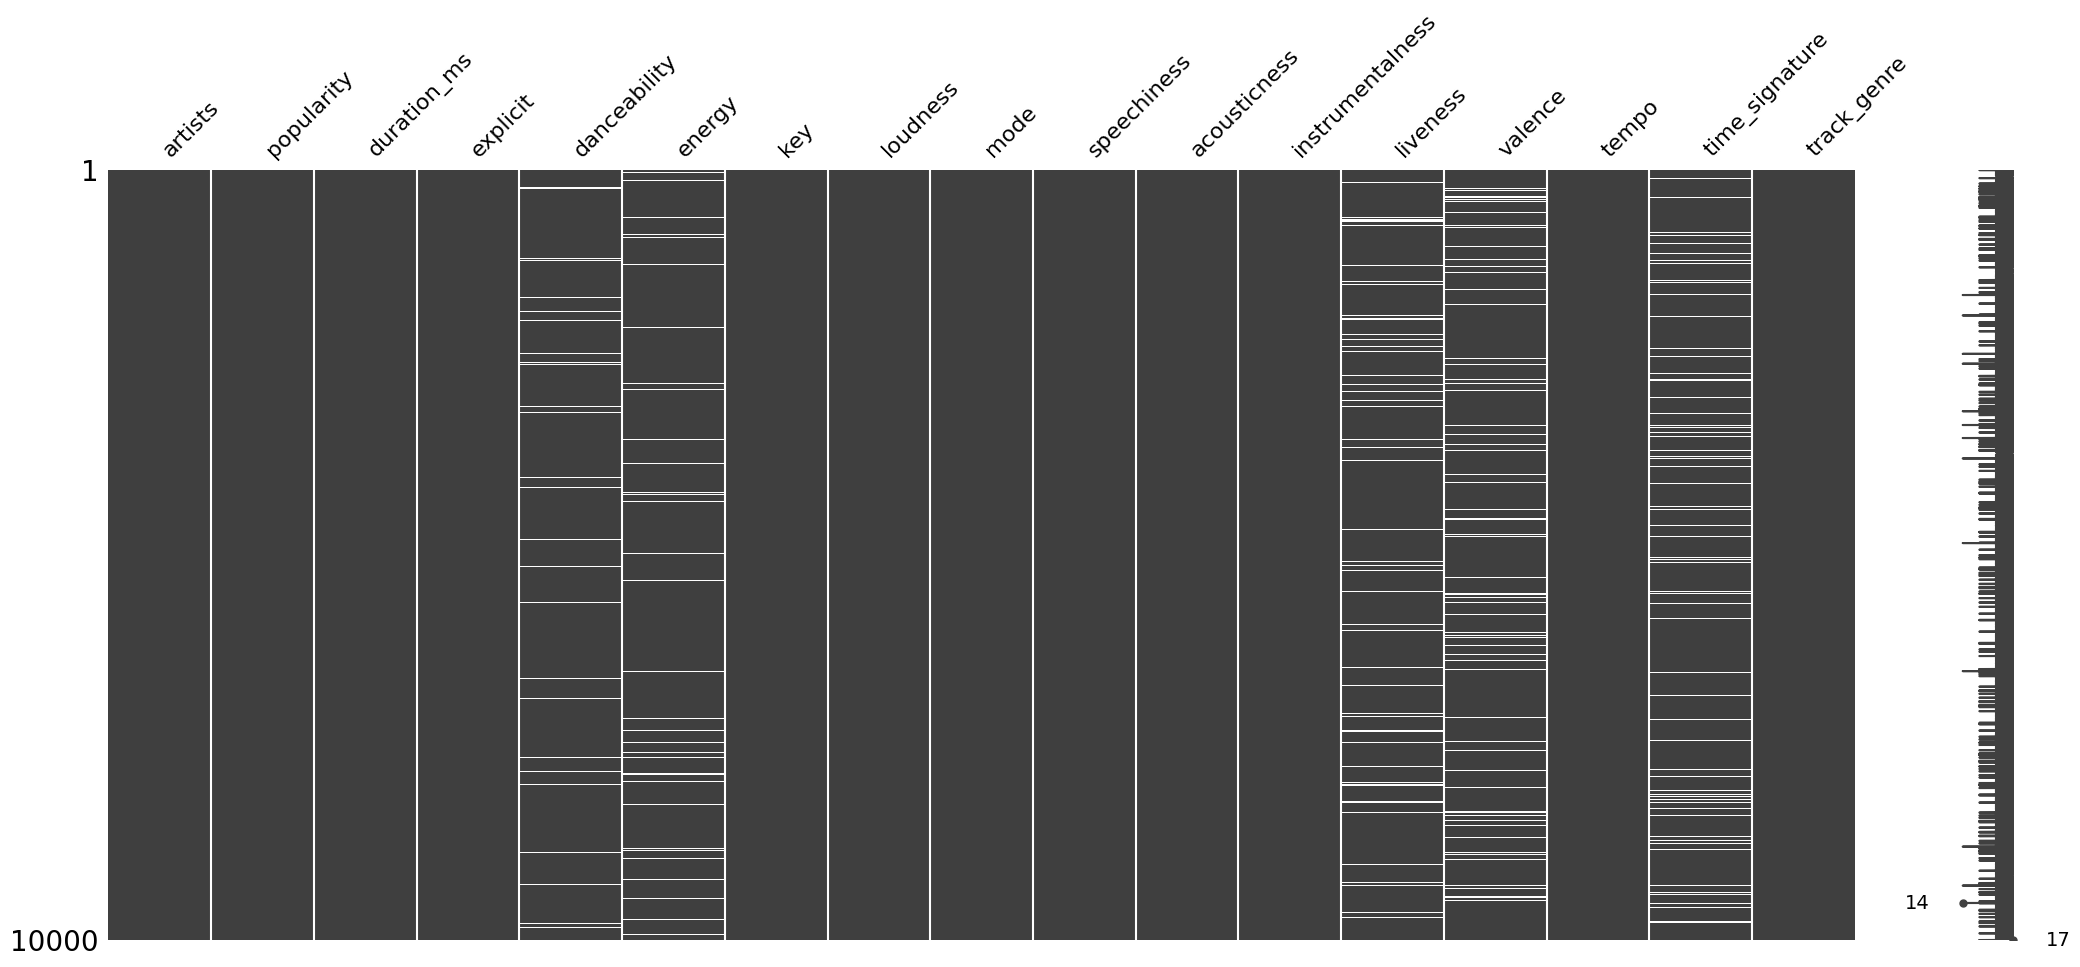

In [137]:
msno.matrix(df)

In [138]:
df.isnull().sum(axis=0)

artists               0
popularity            0
duration_ms           0
explicit              0
danceability        200
energy              500
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness            500
valence             800
tempo                 0
time_signature      800
track_genre           0
dtype: int64

# Raw Data Analysis

## Balanced or imbalanced?

It's very important to know wether our dataset is balanced or imbalanced: this will affect our future choices, for example when deciding to use a sampler or not.

The original dataset was already balanced, so i wanted to keep this feature when generating the reduced dataset. The even distribution can be visualized by plotting an histogram showing the number of instances for each class.

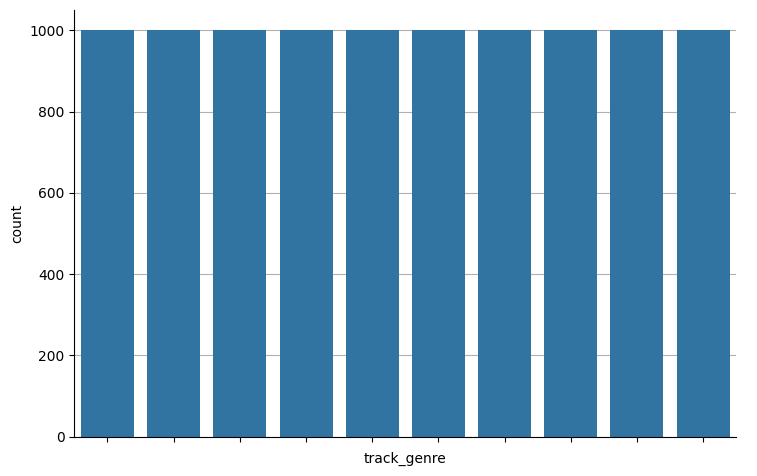

In [139]:
histogram = sns.catplot(data=df, x="track_genre", kind="count", aspect=1.5)
histogram.set_xticklabels([])
histogram.ax.yaxis.grid(True)
histogram.ax.set_axisbelow(True)
plt.show()

## How do our features relate with the genres?

To visualize the relationships between the most characteristic features and our genres, we first generate a new dataset by removing the "artists" column, as it won't be used in this analysis, and by grouping the samples by genre, computing the mean for each remaining column.

We then proceed to plot 15 histograms, showing how the genres distribute based on each feature.

Note that since the reference value for "loudness" is 0, the closer the bar is to it, the louder the genre is. The use of absolute values ensures visual consistency with the other plots.

In [140]:
df_noartists = df.drop(['artists'], axis=1)

df_genres = df_noartists.groupby(['track_genre'], axis=0, as_index=False).mean()

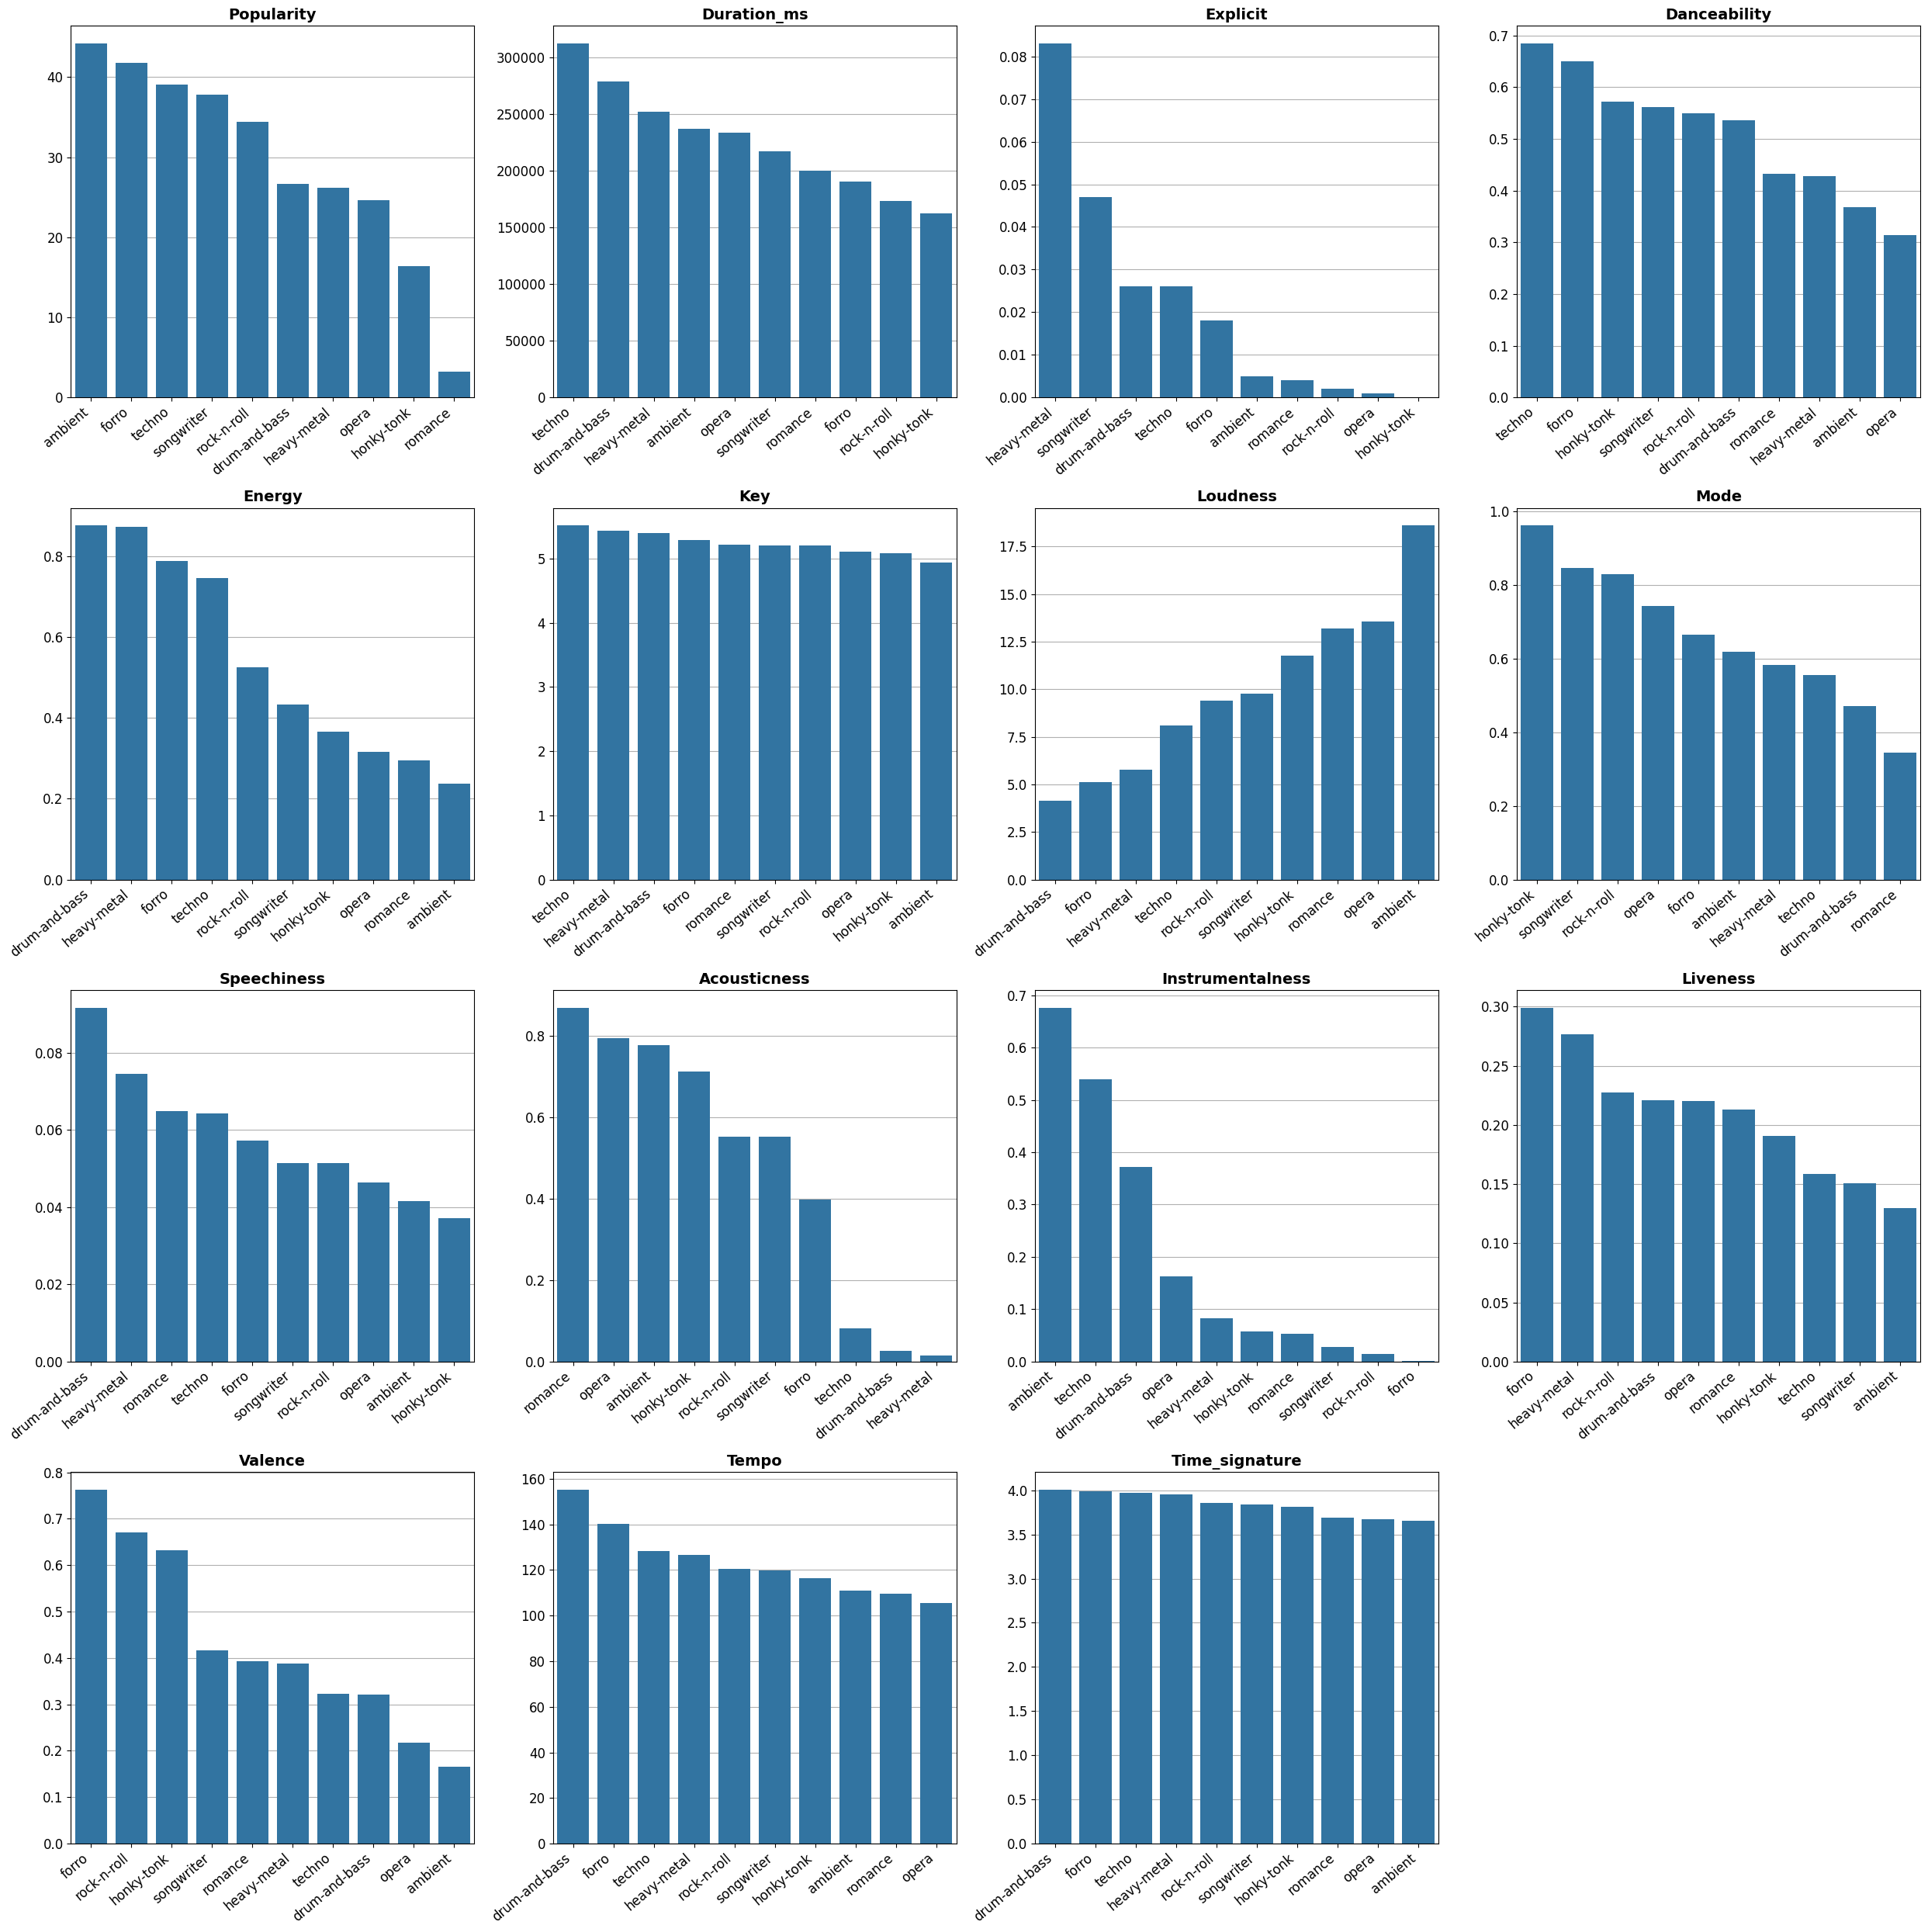

In [141]:
fig, axes = plt.subplots(4, 4, figsize=(25, 25))
axes = axes.flatten()

for i, column in enumerate(df_genres.columns[1:]):
    data = pd.DataFrame(data={'genre': df_genres['track_genre'], 'value': df_genres[column]})
    if column == 'loudness':
        data['value'] = data['value'].abs()
        data = data.sort_values('value')
    else:
        data = data.sort_values('value', ascending=False)
    
    ax = sns.barplot(x="genre", y='value', data=data, ci=None, ax=axes[i])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
    ax.set_title(column.capitalize(), fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(axis='y')
    ax.set_axisbelow(True)

for i in range(len(df_genres.columns[1:]), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()

plt.show()

To visualize how the features correlate with each genre, we plot a correlation matrix. Since the target is composed of strings, we encode each genre by creating 10 dummy variables, one for each genre. Note that in this case the first row is not dropped, since the goal of this encoding is just to plot the matrix.

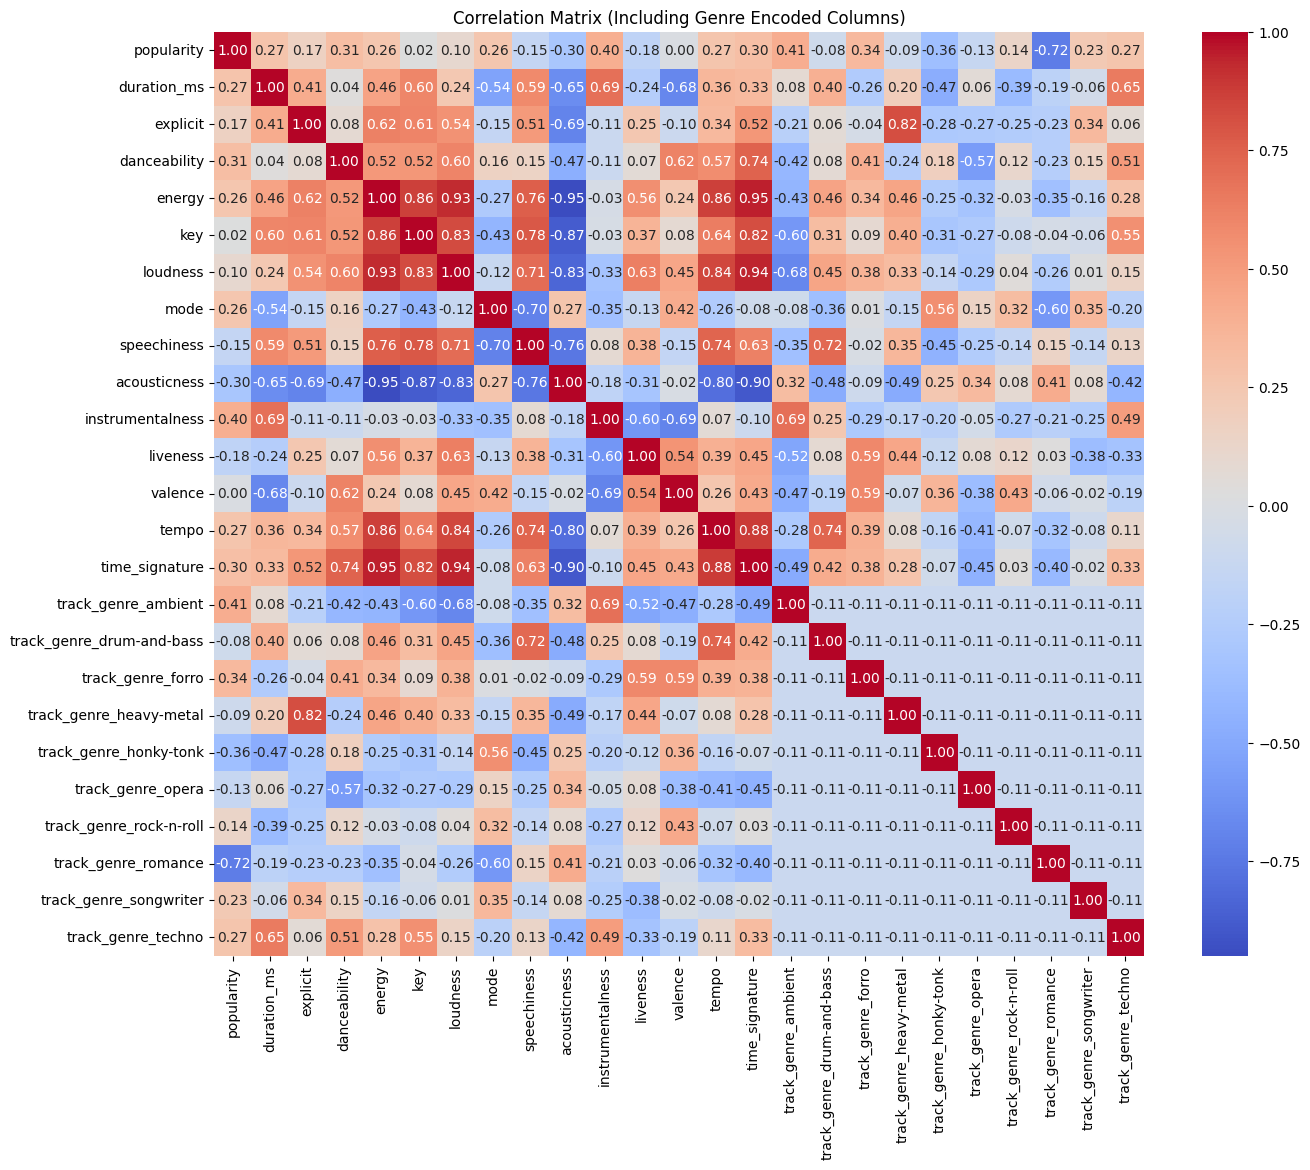

In [142]:
def plot_correlation(encoded_columns):
    df_concatenated = pd.concat([df_genres[numerical_columns], df_encoded[encoded_columns]], axis=1)
    correlation_matrix = df_concatenated.corr()
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix (Including Genre Encoded Columns)")
    plt.show()

numerical_columns = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
df_encoded = pd.get_dummies(df_genres, columns=['track_genre'])
encoded_columns = df_encoded.columns[df_encoded.columns.str.startswith('track_genre_')]

plot_correlation(encoded_columns)

# Data preprocessing

## Data types

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artists           10000 non-null  object 
 1   popularity        10000 non-null  int64  
 2   duration_ms       10000 non-null  int64  
 3   explicit          10000 non-null  bool   
 4   danceability      9800 non-null   float64
 5   energy            9500 non-null   float64
 6   key               10000 non-null  int64  
 7   loudness          10000 non-null  float64
 8   mode              10000 non-null  int64  
 9   speechiness       10000 non-null  float64
 10  acousticness      10000 non-null  float64
 11  instrumentalness  10000 non-null  float64
 12  liveness          9500 non-null   float64
 13  valence           9200 non-null   float64
 14  tempo             10000 non-null  float64
 15  time_signature    9200 non-null   float64
 16  track_genre       10000 non-null  object 

We manually transform the boolean values in the column named "explicit" to integer values, where "True" is mapped to "1" and "False" is mapped to "0".

In [144]:
df['explicit'] = df['explicit'].map({False:0, True:1})
df['explicit']

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: explicit, Length: 10000, dtype: int64

## Pipelines

We proceed by constructing the pipelines to meet our requirements.

In [145]:
pipe_1 = Pipeline(
    [
        ('Mean', SimpleImputer(strategy='mean')),
        ('Scaler', StandardScaler())
    ]
)

pipe_2 = Pipeline(
    [
        ('Median', SimpleImputer(strategy='median')),
        ('Scaler', StandardScaler())
    ]
)

pipe_3 = Pipeline(
    [
        ('Mode', SimpleImputer(strategy='most_frequent'))
    ]
)

## Column Transformer

We assemble the column transformer as follows:
- One-Hot Encoding will be performed on the column containing the artists' names as strings;
- danceability, energy, and liveness will be imputed using the mean to obtain reasonable values, and then standardized;
- valence will be imputed using the median to generate values that don't risk altering the mood of the song, and then standardized;
- time signature will be imputed using the mode since the vast majority of songs nowadays are in 4/4;
- MinMax Scaling will be applied to popularity, loudness, duration, and tempo given they show large values.

In [146]:
song_tf = ColumnTransformer(
    transformers=[
        ('artists', OneHotEncoder(handle_unknown='ignore'), ['artists']),
        ('danceability', pipe_1, ['danceability','energy', 'liveness']),
        ('valence', pipe_2, ['valence']),
        ('time_signature', pipe_3, ['time_signature']),
        ('minmax_scaling', MinMaxScaler(), ['popularity', 'loudness', 'duration_ms', 'tempo'])
    ]
)

# Division in sets and first model

We isolate the target and then divide the dataset into test and training sets, choosing a partition of 20:80.

In [147]:
y = df['track_genre']
X = df.drop(['track_genre'], axis = 1)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42, shuffle=True)

We train our first model and then run a prediction to ensure everything is working correctly. Since our dataset is perfectly balanced, there is no need of using the pipeline from the imbalanced-learn library, we won't use any sampler anyway. Therefore we can rely on the classic pipeline from the scikit-learn library. The sampler step is added only for theoretical completeness.

In [149]:
model_1 = Pipeline([
    ('trans', song_tf),
    ('sampler', None),
    ('dim_reduction', None),
    ('classifier', DecisionTreeClassifier())
])

In [150]:
model_1.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('artists',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artists']),
                                                 ('danceability',
                                                  Pipeline(steps=[('Mean',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'liveness']),
                                                 ('valence',
                                                  Pipeline(steps=[('Median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['valence']),
                                                 ('time_signature',
                                                  Pipeline(steps=[('Mode',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['time_signature']),
                                                 ('minmax_scaling',
                                                  MinMaxScaler(),
                                                  ['popularity', 'loudness',
                                                   'duration_ms', 'tempo'])])),
                ('sampler', None), ('dim_reduction', None),
                ('classifier', DecisionTreeClassifier())])

In [151]:
model_1.predict(X_test)

array(['honky-tonk', 'opera', 'techno', ..., 'forro', 'opera',
       'songwriter'], dtype=object)

## What about scoring?

We compare the four main scoring methods for multiclass classification: accuracy, F1 scoring, prediction and recall. Note that for F1, precision and recall we set the avarage parameter to "macro" for the following reasons:
- we want to give more importance to the classes rather than the single instances;
- weighted avarage is better suited for imbalanced datasets;
- micro avarage gives more importance to the single instances, and it would return the exact same values as accuracy.

Accuracy Scores: [0.753125 0.750625 0.761875 0.718125 0.753125]
F1 macro Scores: [0.75146591 0.75310269 0.76748098 0.725599   0.7461159 ]
Precision macro Scores: [0.75197184 0.74810432 0.77093193 0.72563156 0.75847671]
Recall macro Scores: [0.755    0.75     0.760625 0.724375 0.75125 ]


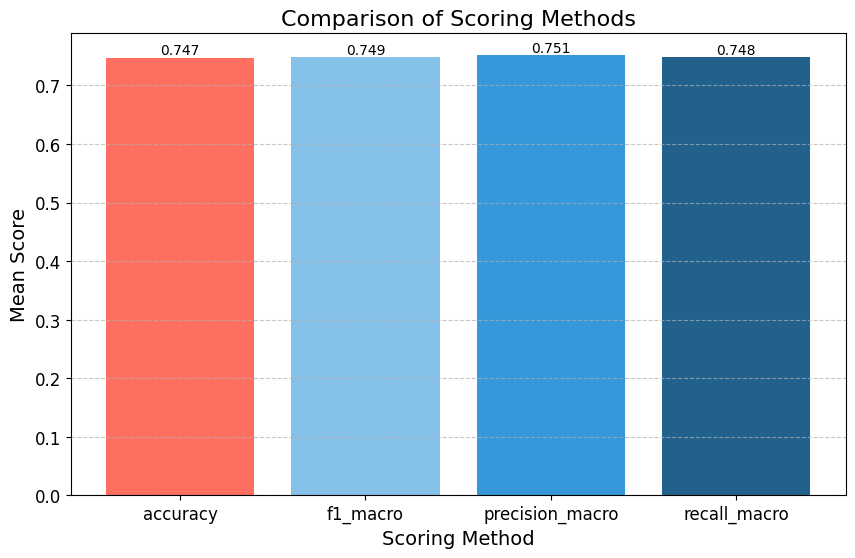

In [152]:
scoring_methods = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
scores = {}

for method in scoring_methods:
    scores[method] = cross_val_score(model_1, X_train, y_train, cv=5, scoring=method)
    print(f"{method.capitalize().replace('_', ' ')} Scores:", scores[method])

mean_scores = {method: np.mean(score) for method, score in scores.items()}

plt.figure(figsize=(10, 6))
bars = plt.bar(mean_scores.keys(), mean_scores.values(), color=['#FF6F61', '#85C1E9', '#3498DB', '#21618C'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', color='black')

plt.title('Comparison of Scoring Methods', fontsize=16)
plt.xlabel('Scoring Method', fontsize=14)
plt.ylabel('Mean Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Given the close values among all scoring methods, I've decided to arbitrarily choose the one that best describes my interest. I don't have specific requirements regarding the precision and recall trade-off, since I don't need to prioritize the most certain positive predictions, nor do i consider the cost of missing a positive instance as too high. My primary concern is to assess the overall performance of my model. Therefore, I've opted for accuracy, as it provides insight into the ratio of correct predictions over the total number of predictions.

In [153]:
model_1.score(X_test, y_test)

0.758

# Best model selection

Performing hyperparameter tuning through cross-validation will enable us to choose the best configuration for our pipeline.

We first specify the configurations for sampling, dimensionality reduction and classification. No sampler will be tried, since our dataset is perfectly balanced. Dimensionality reduction will be carried out using methods that are specific for dealing with sparse matrices like our dataset.

In [154]:
sampler_configs = [
    {
        'sampler': [None]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [TruncatedSVD()],
        'dim_reduction__n_components': [10, 16, 100],
        'dim_reduction__algorithm': ['arpack', 'randomized']
    },
    {
        'dim_reduction': [NMF()],
        'dim_reduction__n_components': [10, 50, 100],
        'dim_reduction__init': ['random', 'nndsvd', 'nndsvda']
    },
    {
        'dim_reduction': [SparseRandomProjection()],
        'dim_reduction__n_components': [10, 50, 100, 'auto'],
        'dim_reduction__dense_output': [True, False]
    }
]

estimator_configs = [
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [87, 89, 91, 93],
        'classifier__weights': ['uniform', 'distance']
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__bootstrap': [True, False]
    },
    {
        'classifier': [OneVsOneClassifier(LinearSVC())],
        'classifier__estimator__C': [0.1, 1.0, 10.0],
        'classifier__estimator__penalty': ['l1', 'l2'],
        'classifier__estimator__dual': ['auto'],
        'classifier__estimator__max_iter': [100000],
        'classifier__n_jobs': [-1]
    },
    {
        'classifier': [OneVsRestClassifier(LinearSVC())],
        'classifier__estimator__C': [0.1, 1.0, 10.0],
        'classifier__estimator__penalty': ['l1', 'l2'],
        'classifier__estimator__dual': ['auto'],
        'classifier__estimator__max_iter': [100000],
        'classifier__n_jobs': [-1]
    }
]

We generate a list of all the possible configurations.

In [155]:
all_configs = []
for config in itertools.product(sampler_configs, dim_reduction_configs, estimator_configs):
    all_parameters = []
    for element in config:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters))

In [156]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 16'

In [157]:
all_configs[:2]

[{'sampler': [None],
  'dim_reduction': [None],
  'classifier': [KNeighborsClassifier()],
  'classifier__n_neighbors': [87, 89, 91, 93],
  'classifier__weights': ['uniform', 'distance']},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [RandomForestClassifier()],
  'classifier__n_estimators': [10, 50, 100, 500],
  'classifier__bootstrap': [True, False]}]

## Cross-validation

It's time for cross-validation. This will enable us to choose the best parameter configuration for our pipeline.

In [158]:
rs = RandomizedSearchCV(model_1,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='accuracy'
)

In [159]:
scores = cross_validate(rs, X_train, y_train, scoring='accuracy', cv = 5, return_estimator=True, verbose=3)

[CV] END ......................................., score=0.902 total time=  25.3s
[CV] END ......................................., score=0.896 total time=  33.1s
[CV] END ......................................., score=0.909 total time=  21.8s
[CV] END ......................................., score=0.851 total time=  31.0s
[CV] END ......................................., score=0.887 total time=  16.3s


In [160]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
OneVsOneClassifier(estimator=LinearSVC(C=10.0, dual='auto', max_iter=100000),
                   n_jobs=-1) {'estimator__C': 10.0, 'estimator__class_weight': None, 'estimator__dual': 'auto', 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 100000, 'estimator__multi_class': 'ovr', 'estimator__penalty': 'l2', 'estimator__random_state': None, 'estimator__tol': 0.0001, 'estimator__verbose': 0, 'estimator': LinearSVC(C=10.0, dual='auto', max_iter=100000), 'n_jobs': -1}
0.9025
----------
None
None
OneVsRestClassifier(estimator=LinearSVC(C=10.0, dual='auto', max_iter=100000,
                                        penalty='l1'),
                    n_jobs=-1) {'estimator__C': 10.0, 'estimator__class_weight': None, 'estimator__dual': 'auto', 'estimator__fit_intercept': True, 'estimator__intercept_scaling': 1, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 100000, 'estimator__multi_class': 'ovr'

In [161]:
best_estimator_index = np.argmax(scores['test_score'])
best_estimator = scores['estimator'][best_estimator_index].best_estimator_
pred_train = best_estimator.fit(X_train, y_train).predict(X_train)
pred_test = best_estimator.predict(X_test)
score_train = accuracy_score(y_train, pred_train)
score_test = accuracy_score(y_test, pred_test)
print(f'Accuracy on training set: {score_train:.4f}, Accuracy on test set: {score_test:.4f}')


Accuracy on training set: 0.9995, Accuracy on test set: 0.9265


Referring to the scores obtained, we can determine the absolute best pipeline configuration.

In [162]:
best_estimator_index = np.argmax(scores['test_score'])
best_estimator = scores['estimator'][best_estimator_index].best_estimator_
best_estimator

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('artists',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['artists']),
                                                 ('danceability',
                                                  Pipeline(steps=[('Mean',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'liveness']),
                                                 ('valence',
                                                  Pipeline(steps=[('Median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['valence']),
                                                 ('time_signature',
                                                  Pipeline(steps=[('Mode',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['time_signature']),
                                                 ('minmax_scaling',
                                                  MinMaxScaler(),
                                                  ['popularity', 'loudness',
                                                   'duration_ms', 'tempo'])])),
                ('sampler', None), ('dim_reduction', None),
                ('classifier',
                 OneVsRestClassifier(estimator=LinearSVC(C=10.0, dual='auto',
                                                         max_iter=100000),
                                     n_jobs=-1))])

We can observe that the best performing model does not utilize sampling or dimensionality reduction. The classifier used is the OVR, through the Linear SVM estimator.

# Hyperparameter tuning

We assemble the final pipeline and tune the classifier and estimator's hyperparameters.

In [163]:
best_model_pipeline = Pipeline([
    ('trans', song_tf),
    ('classifier',OneVsRestClassifier(LinearSVC()))
])

In [164]:
params = {
    'classifier__estimator__C': [1.0, 10.0],
    'classifier__estimator__penalty': ['l1', 'l2'],
    'classifier__estimator__dual': ['auto'],
    'classifier__estimator__max_iter': [100000],
    'classifier__n_jobs': [-1]
}

One last cross-validation is performed.

In [165]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='accuracy'
)

We fit the model.

In [166]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(transformers=[('artists',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['artists']),
                                                                              ('danceability',
                                                                               Pipeline(steps=[('Mean',
                                                                                                SimpleImputer()),
                                                                                               ('Scaler',
                                                                                                StandardScaler())]),
                                                                               ['danceability',
                                                                                'energy',
                                                                                'liveness']),
                                                                              ('valen...
                                                                               ['popularity',
                                                                                'loudness',
                                                                                'duration_ms',
                                                                                'tempo'])])),
                                             ('classifier',
                                              OneVsRestClassifier(estimator=LinearSVC()))]),
                   n_iter=20,
                   param_distributions={'classifier__estimator__C': [1.0, 10.0],
                                        'classifier__estimator__dual': ['auto'],
                                        'classifier__estimator__max_iter': [100000],
                                        'classifier__estimator__penalty': ['l1',
                                                                           'l2'],
                                        'classifier__n_jobs': [-1]},
                   scoring='accuracy')

We run the prediction and print the final score.

In [167]:
score_test = accuracy_score(y_test, rs_best.best_estimator_.predict(X_test))
print(f'Accuracy on test set: {score_test:.4f}')

Accuracy on test set: 0.9265


# Analysis of the results

## Learning curve

We plot the learning curve for our model.

In [168]:
cls = rs_best.best_estimator_

In [169]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'accuracy',
                                                       shuffle = False)

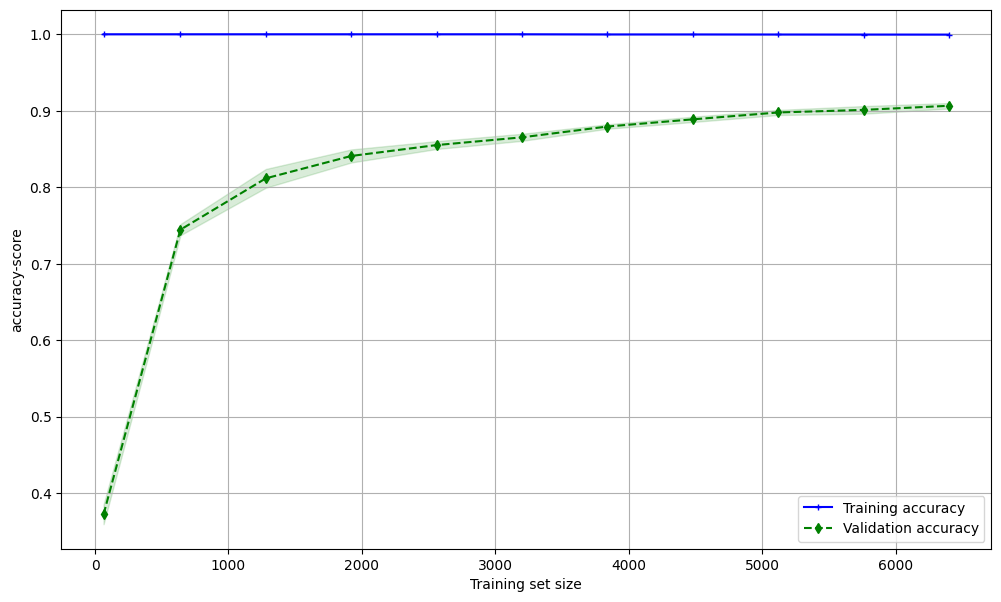

In [170]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('accuracy-score')
ax.legend(loc='lower right')

The learning curve accurately reflects the utilization of Support Vector Machines, as outlined in the scikit-learn documentation. The training curve exhibits a slight deviation from 1, while the validation curve demonstrates a noticeable increase as the training set size expands, resulting in a convergence of the two lines. The confidence interval is characterized by a narrow width, suggesting a low level of uncertainty in the performance estimation.

## Confusion matrix

To visualize the correct or incorrect classification of the genres, we plot a confusion matrix.

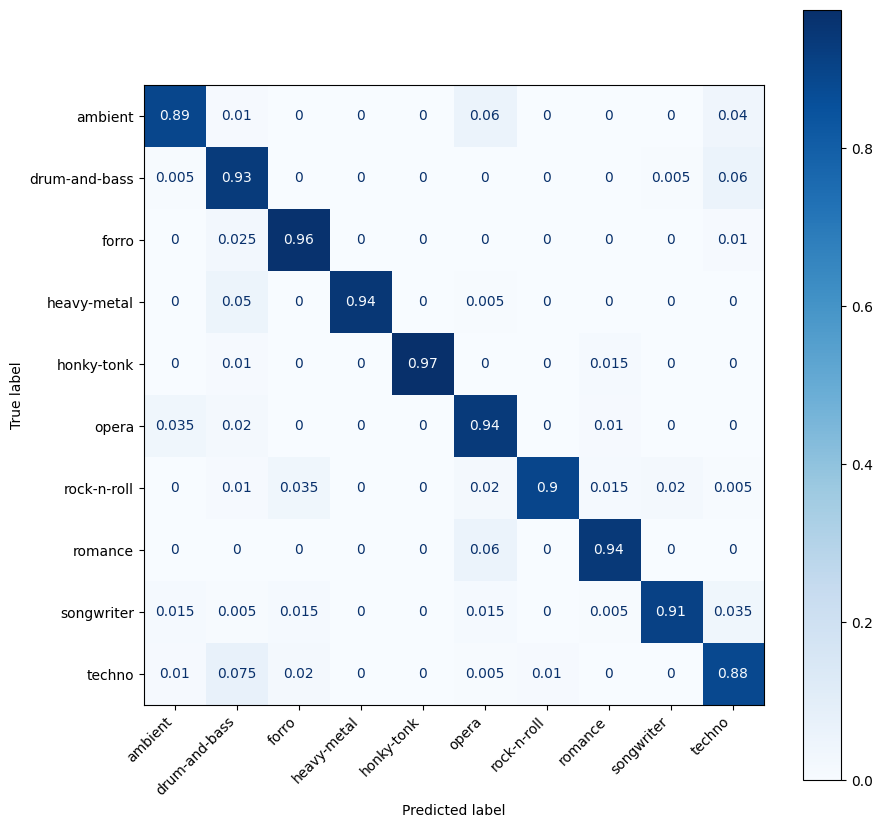

In [171]:
fig, ax = plt.subplots(figsize=(10, 10))
cm_display = ConfusionMatrixDisplay.from_estimator(rs_best, X_test, y_test, normalize='true', ax=ax, cmap='Blues')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees
plt.show()

## Validation curve

Finally, we plot the validation curve.

In [172]:
range_C = [0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_C, 
        param_name='classifier__estimator__C',
        cv=5, 
        n_jobs=-1, 
        scoring='accuracy'
)

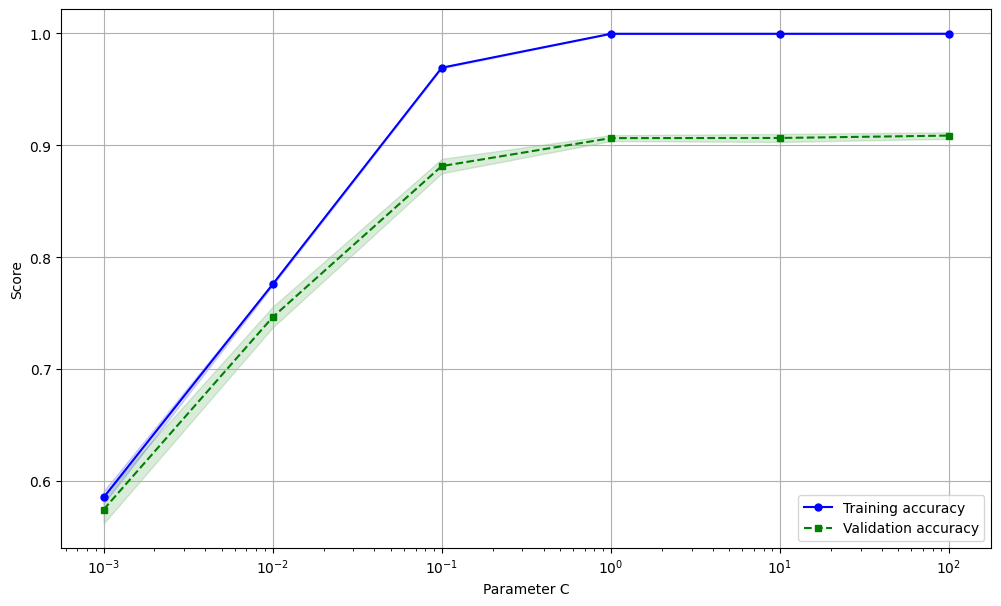

In [173]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('Score')
ax.legend(loc='lower right')
ax.set_xscale('log')

Also in this case, the curve mirrors the one in the documentation. For small values of "C", the model is underfitting, as both the training and the validation curves are very low. The best performance is achieved in the range of "1.0" and "10.0", where we observe a good score in both sets. As the value of "C" grows bigger, an overfitting problem could arise, as the training curve should remain high but the validation curve could start to decrease, indicating an increase in variance.

## Conclusion

We developed a model capable of predicting the genre of a song based on various data features.

The balancing of the data had a significant impact on the model, as evidenced by the absence of sampling and dimensionality reduction in our best-performing model, indicating a naturally low dimensionality of the data. Through randomized search, we finely tuned the hyperparameters, resulting in excellent evaluation metrics and a good score, all while maintaining relatively short runtime. Speaking of scoring, the accuracy method proved to be optimal for evaluating the overall general performance of the model. The One-vs-the-rest Classifier demonstrated its efficiency, consistently outperforming other classifiers across multiple runs.